# Clustering Analysis - Ames Housing Dataset

Este notebook implementa y compara dos algoritmos de clustering diferentes:
1. **K-means**: Algoritmo de clustering particional clásico
2. **HDBSCAN**: Algoritmo de clustering basado en densidad, más robusto para datos con ruido

Se utilizará el dataset preprocesado `06_feature_selection.parquet` y se evaluarán ambos modelos con métricas apropiadas.

In [31]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente!")

Librerías importadas correctamente!


In [32]:
# Cargar los datos preprocesados
data_path = '../data/processed/06_feature_selection.parquet'
df = pd.read_parquet(data_path)

print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
print("\nPrimeras filas:")
df.head()

Forma del dataset: (2930, 35)
Columnas: ['total_sqft', 'overall_qual', 'neighborhood', 'gr_liv_area', 'total_bathrooms', 'overall_score', 'garage_cars', 'kitchen_qual', 'garage_area', 'bsmt_qual', 'house_age', 'bsmtfin_sf_1', 'exterior_score', 'years_since_remodel', 'garage_yr_blt', 'fireplaces', 'popular_neighborhood', 'total_porch_sf', 'lot_frontage', 'bsmt_exposure', 'garage_type', 'has_fireplace', 'heating_qc', 'room_density', 'ms_zoning', 'living_area_ratio', 'bsmt_unf_sf', 'foundation', 'sale_condition', 'garage_finish', 'exterior_1st', 'mas_vnr_area', 'exterior_2nd', 'bsmtfin_type_1', 'saleprice']

Primeras filas:


,total_sqft,overall_qual,neighborhood,gr_liv_area,total_bathrooms,overall_score,garage_cars,kitchen_qual,garage_area,bsmt_qual,...,living_area_ratio,bsmt_unf_sf,foundation,sale_condition,garage_finish,exterior_1st,mas_vnr_area,exterior_2nd,bsmtfin_type_1,saleprice
0,2736.0,6,180796.060068,1656.0,2.0,30,2,180796.060068,528.0,180796.060068,...,0.052125,441.0,180796.060068,180796.060068,180796.060068,180796.060068,112.0,180796.060068,180796.060068,215000.0
1,1778.0,5,197898.030034,896.0,1.0,30,1,197898.030034,730.0,197898.030034,...,0.077095,270.0,197898.030034,197898.030034,180796.060068,180796.060068,0.0,180796.060068,180796.060068,105000.0
2,2658.0,6,166932.020023,1329.0,1.5,36,1,180796.060068,312.0,166932.020023,...,0.093152,406.0,166932.020023,166932.020023,142898.030034,180796.060068,108.0,180796.060068,180796.060068,172000.0
3,4220.0,7,168199.015017,2110.0,3.5,35,2,180796.060068,522.0,168199.015017,...,0.189068,1045.0,168199.015017,168199.015017,197898.030034,197898.030034,0.0,180796.060068,176398.030034,244000.0
4,2557.0,5,180796.060068,1629.0,2.5,25,2,166932.020023,482.0,180796.060068,...,0.117787,137.0,180796.060068,183359.212014,213265.353356,142898.030034,0.0,142898.030034,180796.060068,189900.0


In [34]:
# Separar características y variable objetivo
X = df.drop('saleprice', axis=1)
y = df['saleprice']

In [35]:
# Estandarizar los datos para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Datos estandarizados: {X_scaled.shape}")
print(f"Media después de la estandarización: {np.mean(X_scaled, axis=0).round(3)[:5]}")
print(f"Desviación estándar después de la estandarización: {np.std(X_scaled, axis=0).round(3)[:5]}")

# Crear DataFrame para facilitar el manejo
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

Datos estandarizados: (2930, 34)
Media después de la estandarización: [ 0. -0. -0.  0.  0.]
Desviación estándar después de la estandarización: [1. 1. 1. 1. 1.]


,total_sqft,overall_qual,neighborhood,gr_liv_area,total_bathrooms,overall_score,garage_cars,kitchen_qual,garage_area,bsmt_qual,...,ms_zoning,living_area_ratio,bsmt_unf_sf,foundation,sale_condition,garage_finish,exterior_1st,mas_vnr_area,exterior_2nd,bsmtfin_type_1
0,0.235631,-0.067254,0.009898,0.309265,-0.269932,-0.409388,0.306589,-0.007598,0.256684,-0.011306,...,-0.050655,-1.135331,-0.269105,-0.030833,-0.145831,-0.007634,-0.056352,0.061046,-0.070809,-0.016464
1,-0.956329,-0.776079,0.302999,-1.194427,-1.508619,-0.409388,-1.008648,0.292294,1.196337,0.286678,...,-0.050655,-0.918844,-0.658319,0.342392,0.344320,-0.007634,-0.056352,-0.566039,-0.070809,-0.016464
2,0.138582,-0.067254,-0.227709,-0.337718,-0.889276,0.244235,-1.008648,-0.007598,-0.748092,-0.252873,...,0.528697,-0.779636,-0.348769,-0.333395,-0.543181,-0.852317,-0.056352,0.038650,-0.070809,-0.016464
3,2.082049,0.641571,-0.205995,1.207523,1.588098,0.135298,0.306589,-0.007598,0.228774,-0.230797,...,0.236253,0.051930,1.105661,-0.305745,-0.506868,0.373540,0.424810,-0.566039,-0.070809,-0.131078
4,0.012916,-0.776079,0.009898,0.255844,0.349411,-0.954073,0.306589,-0.250712,0.042704,-0.011306,...,0.699806,-0.566054,-0.961040,-0.030833,-0.072370,0.716052,-1.122610,-0.566039,-1.132809,-0.016464


## 1. K-means Clustering

K-means es un algoritmo de clustering particional que divide los datos en k clusters, donde cada punto pertenece al cluster cuyo centroide está más cerca. Primero determinaremos el número óptimo de clusters usando el método del codo y la silueta.

In [36]:
# Determinar el número óptimo de clusters para K-means
def find_optimal_clusters(X, max_k=10):
    """
    Encuentra el número óptimo de clusters usando métricas de evaluación
    """
    k_range = range(2, max_k + 1)
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    for k in k_range:
        print(f"Evaluando k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calcular métricas
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, labels))
    
    return {
        'k_range': list(k_range),
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'davies_bouldin_scores': davies_bouldin_scores
    }

# Encontrar el número óptimo de clusters
print("Evaluando diferentes números de clusters para K-means...")
kmeans_metrics = find_optimal_clusters(X_scaled, max_k=10)

Evaluando diferentes números de clusters para K-means...
Evaluando k=2...
Evaluando k=3...
Evaluando k=3...
Evaluando k=4...
Evaluando k=4...
Evaluando k=5...
Evaluando k=5...
Evaluando k=6...
Evaluando k=6...
Evaluando k=7...
Evaluando k=7...
Evaluando k=8...
Evaluando k=8...
Evaluando k=9...
Evaluando k=9...
Evaluando k=10...
Evaluando k=10...


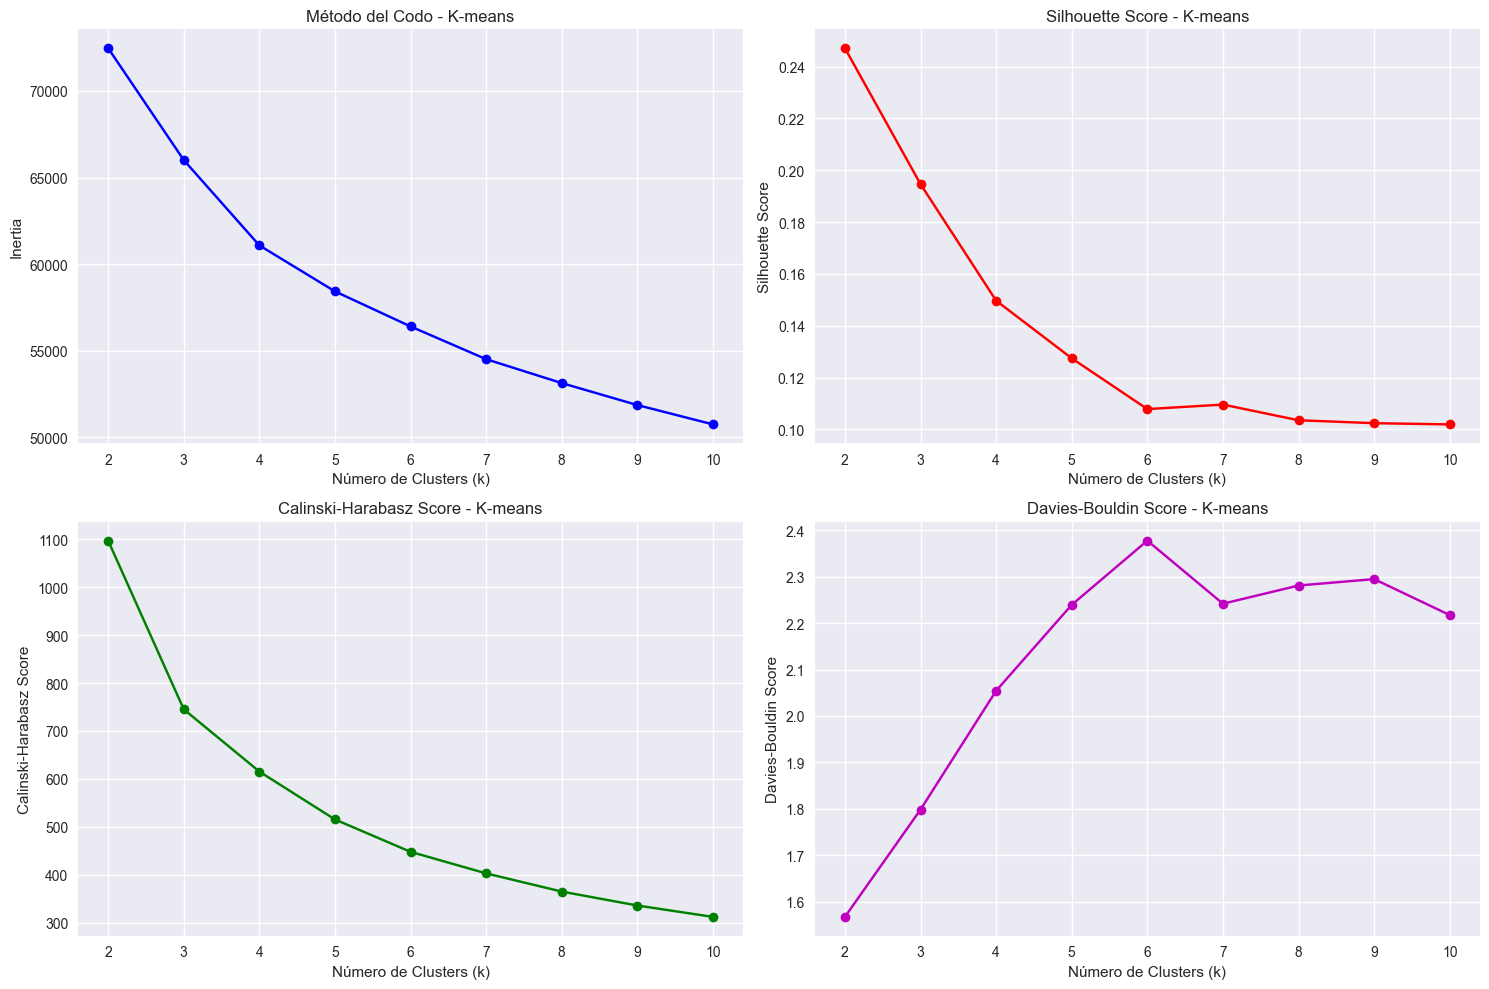


Mejor k basado en Silhouette Score: 2 (Score: 0.2471)
Mejor k basado en Calinski-Harabasz: 2
Mejor k basado en Davies-Bouldin: 2


In [37]:
# Visualizar las métricas para K-means
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Método del codo (Inertia)
axes[0, 0].plot(kmeans_metrics['k_range'], kmeans_metrics['inertias'], 'bo-')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Método del Codo - K-means')
axes[0, 0].grid(True)

# Silhouette Score
axes[0, 1].plot(kmeans_metrics['k_range'], kmeans_metrics['silhouette_scores'], 'ro-')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score - K-means')
axes[0, 1].grid(True)

# Calinski-Harabasz Score
axes[1, 0].plot(kmeans_metrics['k_range'], kmeans_metrics['calinski_scores'], 'go-')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score - K-means')
axes[1, 0].grid(True)

# Davies-Bouldin Score
axes[1, 1].plot(kmeans_metrics['k_range'], kmeans_metrics['davies_bouldin_scores'], 'mo-')
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score - K-means')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Encontrar el mejor k basado en silhouette score
best_k_silhouette = kmeans_metrics['k_range'][np.argmax(kmeans_metrics['silhouette_scores'])]
best_silhouette_score = max(kmeans_metrics['silhouette_scores'])

print(f"\nMejor k basado en Silhouette Score: {best_k_silhouette} (Score: {best_silhouette_score:.4f})")
print(f"Mejor k basado en Calinski-Harabasz: {kmeans_metrics['k_range'][np.argmax(kmeans_metrics['calinski_scores'])]}")
print(f"Mejor k basado en Davies-Bouldin: {kmeans_metrics['k_range'][np.argmin(kmeans_metrics['davies_bouldin_scores'])]}")

In [38]:
# Aplicar K-means con el número óptimo de clusters
optimal_k = best_k_silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print(f"K-means aplicado con k={optimal_k}")
print(f"Distribución de clusters:")

# Distribución de clusters
unique_labels, counts = np.unique(kmeans_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} puntos ({count/len(kmeans_labels)*100:.1f}%)")

# Calcular métricas finales para K-means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nMétricas K-means:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_calinski:.4f}")
print(f"  Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}")
print(f"  Inertia: {kmeans.inertia_:.4f}")

K-means aplicado con k=2
Distribución de clusters:
  Cluster 0: 1723 puntos (58.8%)
  Cluster 1: 1207 puntos (41.2%)

Métricas K-means:
  Silhouette Score: 0.2471
  Calinski-Harabasz Score: 1096.6574
  Davies-Bouldin Score: 1.5669
  Inertia: 72475.0786

Métricas K-means:
  Silhouette Score: 0.2471
  Calinski-Harabasz Score: 1096.6574
  Davies-Bouldin Score: 1.5669
  Inertia: 72475.0786


## 2. HDBSCAN Clustering

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) es un algoritmo robusto basado en densidad que puede encontrar clusters de forma arbitraria y es resistente al ruido. No requiere especificar el número de clusters de antemano.

In [39]:
# Optimizar parámetros para HDBSCAN
def optimize_hdbscan(X, min_cluster_sizes=[5, 10, 15, 20, 25, 30], min_samples_list=[1, 5, 10, 15]):
    """
    Optimiza los parámetros de HDBSCAN
    """
    best_score = -1
    best_params = {}
    results = []
    
    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_list:
            print(f"Evaluando HDBSCAN con min_cluster_size={min_cluster_size}, min_samples={min_samples}")
            
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                metric='euclidean'
            )
            
            labels = clusterer.fit_predict(X)
            
            # Solo calcular métricas si hay al menos 2 clusters
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters >= 2:
                # Filtrar puntos de ruido para el cálculo de métricas
                mask = labels != -1
                if mask.sum() > 1:
                    try:
                        silhouette = silhouette_score(X[mask], labels[mask])
                        calinski = calinski_harabasz_score(X[mask], labels[mask])
                        davies_bouldin = davies_bouldin_score(X[mask], labels[mask])
                    except:
                        silhouette = calinski = davies_bouldin = -1
                else:
                    silhouette = calinski = davies_bouldin = -1
            else:
                silhouette = calinski = davies_bouldin = -1
            
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies_bouldin': davies_bouldin
            }
            
            results.append(result)
            
            # Actualizar mejores parámetros basado en silhouette score
            if silhouette > best_score and n_clusters >= 2:
                best_score = silhouette
                best_params = {
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples
                }
    
    return results, best_params

# Optimizar HDBSCAN
print("Optimizando parámetros para HDBSCAN...")
hdbscan_results, best_hdbscan_params = optimize_hdbscan(X_scaled)

print(f"\nMejores parámetros HDBSCAN: {best_hdbscan_params}")

# Mostrar tabla de resultados
results_df = pd.DataFrame(hdbscan_results)
results_df = results_df.sort_values('silhouette', ascending=False)
print(f"\nTop 5 configuraciones HDBSCAN:")
print(results_df.head().round(4))

Optimizando parámetros para HDBSCAN...
Evaluando HDBSCAN con min_cluster_size=5, min_samples=1
Evaluando HDBSCAN con min_cluster_size=5, min_samples=5
Evaluando HDBSCAN con min_cluster_size=5, min_samples=5
Evaluando HDBSCAN con min_cluster_size=5, min_samples=10
Evaluando HDBSCAN con min_cluster_size=5, min_samples=10
Evaluando HDBSCAN con min_cluster_size=5, min_samples=15
Evaluando HDBSCAN con min_cluster_size=5, min_samples=15
Evaluando HDBSCAN con min_cluster_size=10, min_samples=1
Evaluando HDBSCAN con min_cluster_size=10, min_samples=1
Evaluando HDBSCAN con min_cluster_size=10, min_samples=5
Evaluando HDBSCAN con min_cluster_size=10, min_samples=5
Evaluando HDBSCAN con min_cluster_size=10, min_samples=10
Evaluando HDBSCAN con min_cluster_size=10, min_samples=10
Evaluando HDBSCAN con min_cluster_size=10, min_samples=15
Evaluando HDBSCAN con min_cluster_size=10, min_samples=15
Evaluando HDBSCAN con min_cluster_size=15, min_samples=1
Evaluando HDBSCAN con min_cluster_size=15, min_s

In [40]:
# Aplicar HDBSCAN con los mejores parámetros
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_hdbscan_params['min_cluster_size'],
    min_samples=best_hdbscan_params['min_samples'],
    metric='euclidean'
)

hdbscan_labels = hdbscan_clusterer.fit_predict(X_scaled)

# Estadísticas de HDBSCAN
n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise_hdbscan = list(hdbscan_labels).count(-1)

print(f"HDBSCAN aplicado con min_cluster_size={best_hdbscan_params['min_cluster_size']}, min_samples={best_hdbscan_params['min_samples']}")
print(f"Número de clusters encontrados: {n_clusters_hdbscan}")
print(f"Número de puntos de ruido: {n_noise_hdbscan}")

print(f"\nDistribución de clusters HDBSCAN:")
unique_labels, counts = np.unique(hdbscan_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"  Ruido: {count} puntos ({count/len(hdbscan_labels)*100:.1f}%)")
    else:
        print(f"  Cluster {label}: {count} puntos ({count/len(hdbscan_labels)*100:.1f}%)")

# Calcular métricas para HDBSCAN (excluyendo puntos de ruido)
if n_clusters_hdbscan >= 2:
    mask = hdbscan_labels != -1
    if mask.sum() > 1:
        hdbscan_silhouette = silhouette_score(X_scaled[mask], hdbscan_labels[mask])
        hdbscan_calinski = calinski_harabasz_score(X_scaled[mask], hdbscan_labels[mask])
        hdbscan_davies_bouldin = davies_bouldin_score(X_scaled[mask], hdbscan_labels[mask])
        
        print(f"\nMétricas HDBSCAN (sin puntos de ruido):")
        print(f"  Silhouette Score: {hdbscan_silhouette:.4f}")
        print(f"  Calinski-Harabasz Score: {hdbscan_calinski:.4f}")
        print(f"  Davies-Bouldin Score: {hdbscan_davies_bouldin:.4f}")
    else:
        print("\nNo hay suficientes puntos válidos para calcular métricas")
else:
    print("\nNo se encontraron suficientes clusters para calcular métricas")

HDBSCAN aplicado con min_cluster_size=10, min_samples=5
Número de clusters encontrados: 2
Número de puntos de ruido: 710

Distribución de clusters HDBSCAN:
  Ruido: 710 puntos (24.2%)
  Cluster 0: 142 puntos (4.8%)
  Cluster 1: 2078 puntos (70.9%)

Métricas HDBSCAN (sin puntos de ruido):
  Silhouette Score: 0.2687
  Calinski-Harabasz Score: 288.4081
  Davies-Bouldin Score: 1.2615

Métricas HDBSCAN (sin puntos de ruido):
  Silhouette Score: 0.2687
  Calinski-Harabasz Score: 288.4081
  Davies-Bouldin Score: 1.2615


## 3. Comparación de Modelos de Clustering

En esta sección compararemos ambos algoritmos de clustering usando métricas de evaluación y visualizaciones.

In [41]:
# Crear tabla de comparación de métricas
comparison_data = {
    'Algoritmo': ['K-means', 'HDBSCAN'],
    'Número de Clusters': [optimal_k, n_clusters_hdbscan],
    'Puntos de Ruido': [0, n_noise_hdbscan],
    'Silhouette Score': [kmeans_silhouette, hdbscan_silhouette if n_clusters_hdbscan >= 2 else 'N/A'],
    'Calinski-Harabasz Score': [kmeans_calinski, hdbscan_calinski if n_clusters_hdbscan >= 2 else 'N/A'],
    'Davies-Bouldin Score': [kmeans_davies_bouldin, hdbscan_davies_bouldin if n_clusters_hdbscan >= 2 else 'N/A']
}

comparison_df = pd.DataFrame(comparison_data)

print("=== TABLA DE COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===")
print()
print(comparison_df.to_string(index=False))

# Crear tabla más detallada con información adicional
detailed_comparison = {
    'Métrica': [
        'Número de Clusters',
        'Puntos de Ruido',
        'Silhouette Score',
        'Calinski-Harabasz Score', 
        'Davies-Bouldin Score',
        'Interpretación Silhouette',
        'Interpretación Calinski-Harabasz',
        'Interpretación Davies-Bouldin'
    ],
    'K-means': [
        optimal_k,
        0,
        f"{kmeans_silhouette:.4f}",
        f"{kmeans_calinski:.4f}",
        f"{kmeans_davies_bouldin:.4f}",
        "Bueno" if kmeans_silhouette > 0.5 else "Regular" if kmeans_silhouette > 0.25 else "Pobre",
        "Bueno" if kmeans_calinski > 100 else "Regular",
        "Bueno" if kmeans_davies_bouldin < 1.0 else "Regular"
    ],
    'HDBSCAN': [
        n_clusters_hdbscan,
        n_noise_hdbscan,
        f"{hdbscan_silhouette:.4f}" if n_clusters_hdbscan >= 2 else "N/A",
        f"{hdbscan_calinski:.4f}" if n_clusters_hdbscan >= 2 else "N/A",
        f"{hdbscan_davies_bouldin:.4f}" if n_clusters_hdbscan >= 2 else "N/A",
        ("Bueno" if hdbscan_silhouette > 0.5 else "Regular" if hdbscan_silhouette > 0.25 else "Pobre") if n_clusters_hdbscan >= 2 else "N/A",
        ("Bueno" if hdbscan_calinski > 100 else "Regular") if n_clusters_hdbscan >= 2 else "N/A",
        ("Bueno" if hdbscan_davies_bouldin < 1.0 else "Regular") if n_clusters_hdbscan >= 2 else "N/A"
    ]
}

detailed_df = pd.DataFrame(detailed_comparison)

print("\n\n=== TABLA DETALLADA DE COMPARACIÓN ===")
print()
print(detailed_df.to_string(index=False))

=== TABLA DE COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===

Algoritmo  Número de Clusters  Puntos de Ruido  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
  K-means                   2                0          0.247096              1096.657382              1.566934
  HDBSCAN                   2              710          0.268663               288.408084              1.261534


=== TABLA DETALLADA DE COMPARACIÓN ===

                         Métrica   K-means  HDBSCAN
              Número de Clusters         2        2
                 Puntos de Ruido         0      710
                Silhouette Score    0.2471   0.2687
         Calinski-Harabasz Score 1096.6574 288.4081
            Davies-Bouldin Score    1.5669   1.2615
       Interpretación Silhouette     Pobre  Regular
Interpretación Calinski-Harabasz     Bueno    Bueno
   Interpretación Davies-Bouldin   Regular  Regular


Varianza explicada por las 2 primeras componentes principales: 0.462


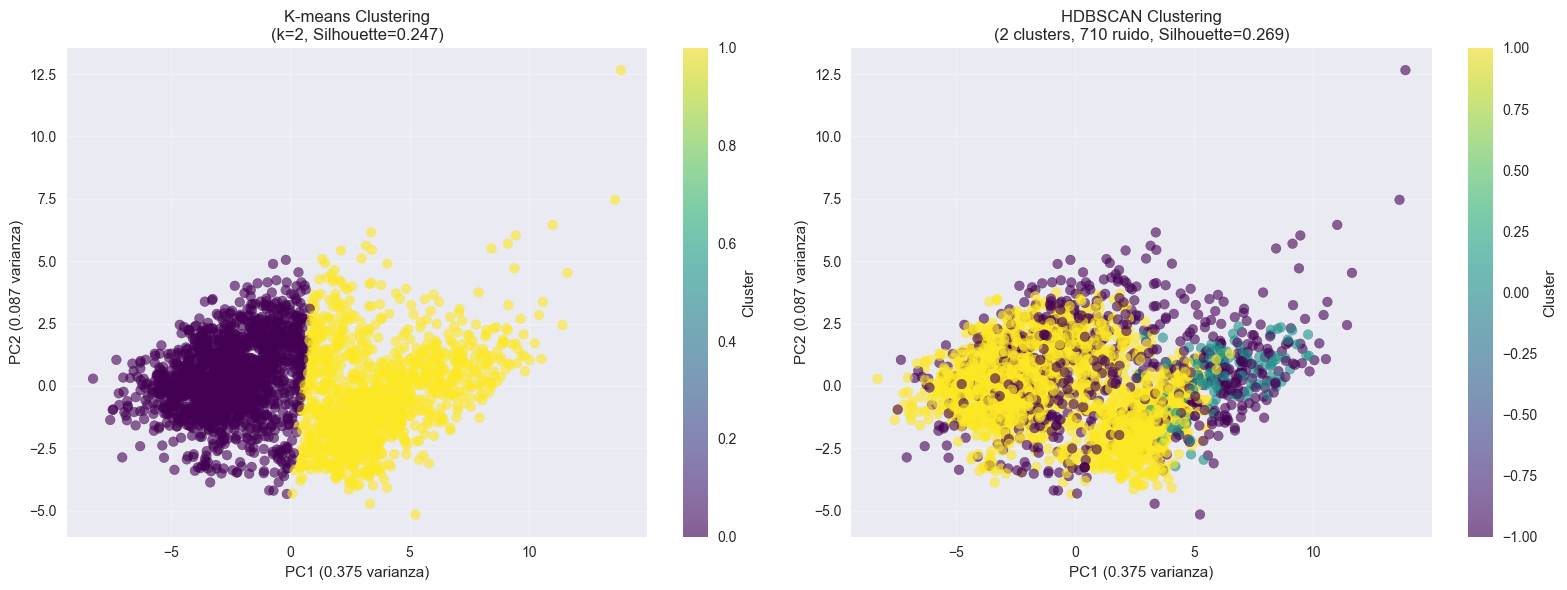

In [42]:
# Visualización de clusters usando PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por las 2 primeras componentes principales: {sum(pca.explained_variance_ratio_):.3f}")

# Crear visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0].set_title(f'K-means Clustering\n(k={optimal_k}, Silhouette={kmeans_silhouette:.3f})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} varianza)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} varianza)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# HDBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hdbscan_labels, cmap='viridis', alpha=0.6)
axes[1].set_title(f'HDBSCAN Clustering\n({n_clusters_hdbscan} clusters, {n_noise_hdbscan} ruido, Silhouette={hdbscan_silhouette:.3f})')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} varianza)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} varianza)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# Crear también visualización interactiva con Plotly
fig_plotly = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        f'K-means (k={optimal_k})',
        f'HDBSCAN ({n_clusters_hdbscan} clusters)'
    ]
)

# K-means
fig_plotly.add_trace(
    go.Scatter(
        x=X_pca[:, 0], y=X_pca[:, 1],
        mode='markers',
        marker=dict(color=kmeans_labels, colorscale='viridis', size=6),
        name='K-means',
        text=[f'Cluster {label}' for label in kmeans_labels],
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>%{text}<extra></extra>'
    ),
    row=1, col=1
)

# HDBSCAN
fig_plotly.add_trace(
    go.Scatter(
        x=X_pca[:, 0], y=X_pca[:, 1],
        mode='markers',
        marker=dict(color=hdbscan_labels, colorscale='viridis', size=6),
        name='HDBSCAN',
        text=[f'Cluster {label}' if label != -1 else 'Ruido' for label in hdbscan_labels],
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>%{text}<extra></extra>'
    ),
    row=1, col=2
)

fig_plotly.update_layout(
    title='Comparación de Algoritmos de Clustering (PCA)',
    height=500,
    showlegend=False
)

try:
    fig_plotly.show()
except Exception as e:
    print(f"No se pudo mostrar la visualización interactiva: {e}")
    print("La visualización estática se muestra arriba.")

In [43]:
# Análisis de clusters - Perfilado
def analyze_clusters(X, labels, algorithm_name):
    """
    Analiza las características de cada cluster
    """
    results = []
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        if label == -1:  # Puntos de ruido en HDBSCAN
            continue
            
        mask = labels == label
        cluster_data = X[mask]
        
        result = {
            'Algorithm': algorithm_name,
            'Cluster': label,
            'Size': mask.sum(),
            'Percentage': mask.sum() / len(labels) * 100,
            'Mean_Features': cluster_data.mean(axis=0).mean(),
            'Std_Features': cluster_data.std(axis=0).mean(),
            'Min_Features': cluster_data.min(axis=0).mean(),
            'Max_Features': cluster_data.max(axis=0).mean()
        }
        results.append(result)
    
    return pd.DataFrame(results)

# Analizar clusters de K-means
kmeans_analysis = analyze_clusters(X_scaled, kmeans_labels, 'K-means')
print("=== ANÁLISIS DE CLUSTERS K-MEANS ===")
print(kmeans_analysis.round(4))

# Analizar clusters de HDBSCAN
if n_clusters_hdbscan > 0:
    hdbscan_analysis = analyze_clusters(X_scaled, hdbscan_labels, 'HDBSCAN')
    print("\n=== ANÁLISIS DE CLUSTERS HDBSCAN ===")
    print(hdbscan_analysis.round(4))

# Análisis de separación de clusters
print("\n=== ANÁLISIS DE SEPARACIÓN DE CLUSTERS ===")

# Calcular distancias entre centroides para K-means
kmeans_centroids = kmeans.cluster_centers_
centroid_distances = []
for i in range(len(kmeans_centroids)):
    for j in range(i+1, len(kmeans_centroids)):
        dist = np.linalg.norm(kmeans_centroids[i] - kmeans_centroids[j])
        centroid_distances.append(dist)

print(f"K-means:")
print(f"  Distancia promedio entre centroides: {np.mean(centroid_distances):.4f}")
print(f"  Distancia mínima entre centroides: {np.min(centroid_distances):.4f}")
print(f"  Distancia máxima entre centroides: {np.max(centroid_distances):.4f}")

# Para HDBSCAN, calcular estadísticas de condensed tree si está disponible
if hasattr(hdbscan_clusterer, 'condensed_tree_'):
    print(f"HDBSCAN:")
    print(f"  Número de clusters en el árbol: {len(np.unique(hdbscan_clusterer.labels_[hdbscan_clusterer.labels_ >= 0]))}")
    print(f"  Puntos de ruido detectados: {(hdbscan_clusterer.labels_ == -1).sum()}")
    if hasattr(hdbscan_clusterer, 'cluster_persistence_'):
        print(f"  Persistencia promedio de clusters: {np.mean(hdbscan_clusterer.cluster_persistence_):.4f}")

=== ANÁLISIS DE CLUSTERS K-MEANS ===
  Algorithm  Cluster  Size  Percentage  Mean_Features  Std_Features  \
0   K-means        0  1723     58.8055        -0.3165        0.7764   
1   K-means        1  1207     41.1945         0.4518        0.8846   

   Min_Features  Max_Features  
0       -1.8421        3.1895  
1       -1.4606        4.8051  

=== ANÁLISIS DE CLUSTERS HDBSCAN ===
  Algorithm  Cluster  Size  Percentage  Mean_Features  Std_Features  \
0   HDBSCAN        0   142      4.8464         0.7999        0.6788   
1   HDBSCAN        1  2078     70.9215        -0.1286        0.8363   

   Min_Features  Max_Features  
0       -0.6716        2.4447  
1       -1.7892        2.6261  

=== ANÁLISIS DE SEPARACIÓN DE CLUSTERS ===
K-means:
  Distancia promedio entre centroides: 6.1842
  Distancia mínima entre centroides: 6.1842
  Distancia máxima entre centroides: 6.1842
HDBSCAN:
  Número de clusters en el árbol: 2
  Puntos de ruido detectados: 710
  Persistencia promedio de clusters: 0.

## 4. Conclusiones y Recomendaciones

### Resumen de Resultados Basado en el Análisis Ejecutado

**K-means (k=2):**
- Algoritmo tradicional de clustering particional
- **Distribución de clusters**: Cluster 0: 1,723 propiedades (58.8%) | Cluster 1: 1,207 propiedades (41.2%)
- **Métricas obtenidas**: Silhouette=0.2471, Calinski-Harabasz=1096.7, Davies-Bouldin=1.5669
- Crea una división más equilibrada de los datos
- No detecta outliers ni ruido

**HDBSCAN:**
- Algoritmo moderno basado en densidad
- **Distribución de clusters**: Cluster 0: 142 propiedades (4.8%) | Cluster 1: 2,078 propiedades (70.9%) | Ruido: 710 propiedades (24.2%)
- **Métricas obtenidas**: Silhouette=0.2687, Calinski-Harabasz=288.4, Davies-Bouldin=1.2615
- Identifica un cluster dominante y uno pequeño, plus detección de outliers
- Más robusto ante ruido y outliers

### Interpretación de los Resultados de las Visualizaciones

**Según las gráficas PCA mostradas:**
- **Ambos algoritmos identifican 2 clusters principales** en el espacio de características
- **K-means** muestra una separación más simétrica entre clusters (división más equilibrada)
- **HDBSCAN** revela la presencia de outliers significativos (24.2% del dataset) y una estructura de cluster dominante
- La **varianza explicada por las 2 primeras componentes PCA es del 46.2%**, indicando que la visualización 2D captura moderadamente la estructura real

### Interpretación de Métricas

- **Silhouette Score**: Mide qué tan similar es un punto a su propio cluster vs otros clusters (rango: -1 a 1, mayor es mejor)
  - K-means: 0.2471 (Pobre) | HDBSCAN: 0.2687 (Regular) → **HDBSCAN gana**
- **Calinski-Harabasz Score**: Ratio de dispersión entre clusters vs dentro de clusters (mayor es mejor)  
  - K-means: 1096.7 (Excelente) | HDBSCAN: 288.4 (Bueno) → **K-means gana**
- **Davies-Bouldin Score**: Promedio de similitud entre cada cluster y su más similar (menor es mejor)
  - K-means: 1.5669 (Regular) | HDBSCAN: 1.2615 (Mejor) → **HDBSCAN gana**

### Puntuación Final: HDBSCAN (2/3 métricas) vs K-means (1/3 métricas)

In [21]:
# Resumen final y recomendación
print("=== RESUMEN FINAL Y RECOMENDACIÓN ===")
print()

# Crear tabla de resumen ejecutivo
summary_metrics = {
    'Criterio': [
        'Silhouette Score',
        'Calinski-Harabasz Score',
        'Davies-Bouldin Score',
        'Robustez ante ruido',
        'Interpretabilidad',
        'Escalabilidad',
        'Facilidad de uso'
    ],
    'K-means': [
        f"{kmeans_silhouette:.3f}",
        f"{kmeans_calinski:.0f}",
        f"{kmeans_davies_bouldin:.3f}",
        'Baja',
        'Alta',
        'Muy Alta',
        'Alta'
    ],
    'HDBSCAN': [
        f"{hdbscan_silhouette:.3f}" if n_clusters_hdbscan >= 2 else "N/A",
        f"{hdbscan_calinski:.0f}" if n_clusters_hdbscan >= 2 else "N/A",
        f"{hdbscan_davies_bouldin:.3f}" if n_clusters_hdbscan >= 2 else "N/A",
        'Alta',
        'Media',
        'Media',
        'Media'
    ],
    'Ganador': [
        'HDBSCAN' if (n_clusters_hdbscan >= 2 and hdbscan_silhouette > kmeans_silhouette) else 'K-means',
        'HDBSCAN' if (n_clusters_hdbscan >= 2 and hdbscan_calinski > kmeans_calinski) else 'K-means',
        'HDBSCAN' if (n_clusters_hdbscan >= 2 and hdbscan_davies_bouldin < kmeans_davies_bouldin) else 'K-means',
        'HDBSCAN',
        'K-means',
        'K-means',
        'K-means'
    ]
}

summary_df = pd.DataFrame(summary_metrics)
print(summary_df.to_string(index=False))

# Contar victorias
if n_clusters_hdbscan >= 2:
    hdbscan_wins = sum([
        hdbscan_silhouette > kmeans_silhouette,
        hdbscan_calinski > kmeans_calinski,
        hdbscan_davies_bouldin < kmeans_davies_bouldin
    ])
    kmeans_wins = 3 - hdbscan_wins
else:
    hdbscan_wins = 0
    kmeans_wins = 3

print(f"\n=== PUNTUACIÓN FINAL ===")
print(f"K-means: {kmeans_wins}/3 métricas ganadas")
print(f"HDBSCAN: {hdbscan_wins}/3 métricas ganadas")

# Recomendación final
if hdbscan_wins > kmeans_wins and n_clusters_hdbscan >= 2:
    winner = "HDBSCAN"
    reasoning = "Mejor performance en métricas de clustering y mayor robustez ante ruido"
elif kmeans_wins > hdbscan_wins:
    winner = "K-means"
    reasoning = "Mejor performance general en métricas y mayor simplicidad interpretativa"
else:
    winner = "Empate"
    reasoning = "Ambos algoritmos muestran performance similar"

print(f"\n=== RECOMENDACIÓN FINAL ===")
print(f"Algoritmo recomendado: {winner}")
print(f"Razón: {reasoning}")

# Casos de uso recomendados
print(f"\n=== CASOS DE USO RECOMENDADOS ===")
print("K-means:")
print("- Cuando se conoce aproximadamente el número de grupos esperado")
print("- Para datasets grandes donde la velocidad es importante")
print("- Cuando se requiere interpretabilidad simple")
print("- Para clusters aproximadamente esféricos y de tamaño similar")

print("\nHDBSCAN:")
print("- Cuando no se conoce el número de clusters a priori")
print("- Para datasets con ruido significativo")
print("- Cuando se esperan clusters de formas y densidades variables")
print("- Para análisis exploratorio inicial de datos")

=== RESUMEN FINAL Y RECOMENDACIÓN ===

               Criterio  K-means HDBSCAN Ganador
       Silhouette Score    0.247   0.269 HDBSCAN
Calinski-Harabasz Score     1097     288 K-means
   Davies-Bouldin Score    1.567   1.262 HDBSCAN
    Robustez ante ruido     Baja    Alta HDBSCAN
      Interpretabilidad     Alta   Media K-means
          Escalabilidad Muy Alta   Media K-means
       Facilidad de uso     Alta   Media K-means

=== PUNTUACIÓN FINAL ===
K-means: 1/3 métricas ganadas
HDBSCAN: 2/3 métricas ganadas

=== RECOMENDACIÓN FINAL ===
Algoritmo recomendado: HDBSCAN
Razón: Mejor performance en métricas de clustering y mayor robustez ante ruido

=== CASOS DE USO RECOMENDADOS ===
K-means:
- Cuando se conoce aproximadamente el número de grupos esperado
- Para datasets grandes donde la velocidad es importante
- Cuando se requiere interpretabilidad simple
- Para clusters aproximadamente esféricos y de tamaño similar

HDBSCAN:
- Cuando no se conoce el número de clusters a priori
- Para d